# Introduction to Dataset
We use the dataset on Kaggle which is scraped from Centaline Property Hong Kong, one of the largest local real estate agencies. It has 159,676 property transaction records during 10/03/2020 to 11/03/2023, showing the detailed information on the date of the transaction, the property address, floor, saleable area etc. The dataset covers a period of time spanning several years.

In this analysis, we will focus on analyzing transactions of private properties in Hong Kong.

### Import Libraries

In [2]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.dates import DateFormatter
import matplotlib.cm as cm

#import csv
#df = pd.read_csv('/kaggle/input/hong-kong-housing-price-2020-2023/Datasetv2.csv')
df = pd.read_csv('./data1/Datasetv2.csv')
# Display basic info and first few rows of the dataset
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159676 entries, 0 to 159675
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           159676 non-null  int64  
 1   date                 159676 non-null  object 
 2   address              159676 non-null  object 
 3   price                159676 non-null  int64  
 4   changes              159676 non-null  object 
 5   saleable_area(ft^2)  159676 non-null  object 
 6   unit_rate            159676 non-null  int64  
 7   district             159676 non-null  object 
 8   Tower                60395 non-null   object 
 9   Flat                 152252 non-null  object 
 10  Phase                48336 non-null   object 
 11  Block                54679 non-null   object 
 12  Rental               159676 non-null  bool   
 13  Public Housing       159676 non-null  bool   
 14  floor                159676 non-null  float64
dtypes: bool(2), float

,Unnamed: 0,date,address,price,changes,saleable_area(ft^2),unit_rate,district,Tower,Flat,Phase,Block,Rental,Public Housing,floor
0,0,9/3/2023,"The Long Beach, Tower 7, Middle Floor, Flat D",33000,--,816,40,Kowloon Kowloon City District,7,D,NaN,NaN,True,False,13.0
1,1,9/3/2023,"One Kai Tak, II, Tower 3, Upper Floor, Flat H",15800,--,375,42,Kowloon Kowloon City District,3,H,NaN,NaN,True,False,22.0
2,2,8/3/2023,"Sky Tower, Block 1, Lower Floor, Flat B",18800,--,520,36,Kowloon Kowloon City District,NaN,B,NaN,1,True,False,7.0
3,3,8/3/2023,"Hampton Place, Tower 2, Upper Floor, Flat F",17000,--,429,40,Kowloon Kowloon City District,2,F,NaN,NaN,True,False,22.0
4,4,8/3/2023,"Skypark, Upper Floor, Flat A5",18000,--,407,44,Kowloon Kowloon City District,NaN,A,NaN,NaN,True,False,22.0


In [3]:
df.shape

(159676, 15)

In [4]:
df.isnull().sum()

Unnamed: 0                  0
date                        0
address                     0
price                       0
changes                     0
saleable_area(ft^2)         0
unit_rate                   0
district                    0
Tower                   99281
Flat                     7424
Phase                  111340
Block                  104997
Rental                      0
Public Housing              0
floor                       0
dtype: int64

In [5]:
df.columns

Index(['Unnamed: 0', 'date', 'address', 'price', 'changes',
       'saleable_area(ft^2)', 'unit_rate', 'district', 'Tower', 'Flat',
       'Phase', 'Block', 'Rental', 'Public Housing', 'floor'],
      dtype='object')

### Data Cleaning and preprocessing

We found column “date” and “seleable_area(ft^2)” are stored as incorrect type - “Object”. Besides correcting “selable_area(ft^2) to numeric and “date” to datetime, we also added 2 more columns of “month_year” and “quarter_year” for higher level analysis.  We then check the null of each column. It is found that “Tower”, “Flat”, “Phase” and “Block” have more then 50% null, and the column “change” have 60% value equal 0. As those columns are not the key elements for the analysis, we decided to drop them off from our dataframe. Considering the data of 2020 Mar and 2023 March are not complete, we excluded it  from our analysis. Also, the size of public houses is too little, 1,554 out of 159,676, so we decided to focus on private property only and exclude public housing.Too many distinct values of a variable sometimes is hard for delivering insight. We regroup 18 “district” to 4 regions and “seable_are(ft^2)” to 3 flat sizes, detail coding as below:


In [6]:
# rename columns
new_column_names = {
    'Tower': 'tower',
    'Flat': 'flat',
    'Phase': 'phase',
    'Block': 'block',
    'Rental': 'is_rental',
    'Public Housing': 'is_public_housing',
}

df = df.rename(columns=new_column_names)

# Verify the changes
print(df.columns)

Index(['Unnamed: 0', 'date', 'address', 'price', 'changes',
       'saleable_area(ft^2)', 'unit_rate', 'district', 'tower', 'flat',
       'phase', 'block', 'is_rental', 'is_public_housing', 'floor'],
      dtype='object')


In [7]:
#convert data type of date from object to datetime
df['date'] = pd.to_datetime(df['date'], format="%d/%m/%Y", errors='coerce')

# Extract month and year for grouping
df['month_year'] = df['date'].dt.to_period('M')

In [8]:
# Drop rows where the date is in March 2023 and March 2020 
df = df[~((df['date'].dt.year == 2023) & (df['date'].dt.month == 3))]

In [9]:
#Function to remove comma from column and convert price strings to numeric
def convert_numeric(value):
    if isinstance(value, str):
        return pd.to_numeric(value.replace(',', ''), errors='coerce')
    return value
df['saleable_area(ft^2)'] = df['saleable_area(ft^2)'].apply(convert_numeric)

In [10]:
# Categorize properties by size and add category column
def categorize_size(area):
    if area < 500:
        return 'Small'
    elif 500 <= area <= 1000:
        return 'Medium'
    else:
        return 'Large'
    
df['property_size'] = df['saleable_area(ft^2)'].apply(categorize_size)

In [11]:
# Categorize 18 districts by 3 regions
district_region = {
    'Kowloon Kowloon City District': 'KLN' ,
    'Kowloon Kwun Tong District' : 'KLN',
    'Kowloon Yau Tsim Mong District' : 'KLN' , 
    'Kowloon Wong Tai Sin District' : 'KLN' ,
    'Kowloon Sham Shui Po District' : 'KLN' ,
    'New Territories East Sha Tin District' : 'NTEast' ,
    'New Territories East Long Ping Estate' : 'NTEast' ,
    'New Territories East North District' : 'NTEast' ,
    'New Territories East Tai Po District' : 'NTEast' , 
    'Kwai Tsing District' : 'NTWest' ,
    'Tsuen Wan District' : 'NTWest' , 
    'Yuen Long District' : 'NTWest' , 
    'Tuen Mun District' : 'NTWest' ,
    'New Territories West Islands District' : 'NTWest' ,
    'Wan Chai District' : 'HK',
    'HKIsIand Southern District' : 'HK', 
    'Central and Western District' : 'HK',
    'HKIsIand Eastern District' : 'HK'
}

df['region'] = df['district'].map(district_region)

In [12]:
df.columns

Index(['Unnamed: 0', 'date', 'address', 'price', 'changes',
       'saleable_area(ft^2)', 'unit_rate', 'district', 'tower', 'flat',
       'phase', 'block', 'is_rental', 'is_public_housing', 'floor',
       'month_year', 'property_size', 'region'],
      dtype='object')

Before creating plots, we create Dataframes of private private property selling market and private property rental market respectively for easy reference.

In [13]:
# Filter for private properties
df_private = df[df['is_public_housing'] == False]

# Filter data for private sold properties
private_sold = df_private[df_private['is_rental'] == False]

# Filter data for private rental properties
private_rental = df_private[df_private['is_rental'] == True]

sold_monthly = private_sold.groupby('month_year')['unit_rate'].mean()

rental_monthly = private_rental.groupby('month_year')['unit_rate'].mean()


## Overview of Hong Kong Property Market

### Unit Rate Movement of Private Property

Lets have a brief overview of the unit rate movement of private property by month and the no. of transactions of rental and sold properties per month to get an overall picture of private housing in Hong Kong. 

According to the line plot of private selling market and rental market below, the price were highly fluctuated from 2020 to 2023. However, the price per sq. ft. of both sold and rental properties were in a downward trend. This plot shows that the Hong Kong housing market has been experiencing a decline in property prices. It is possibly due to the impact of COVID 19 and the rising interest rates.

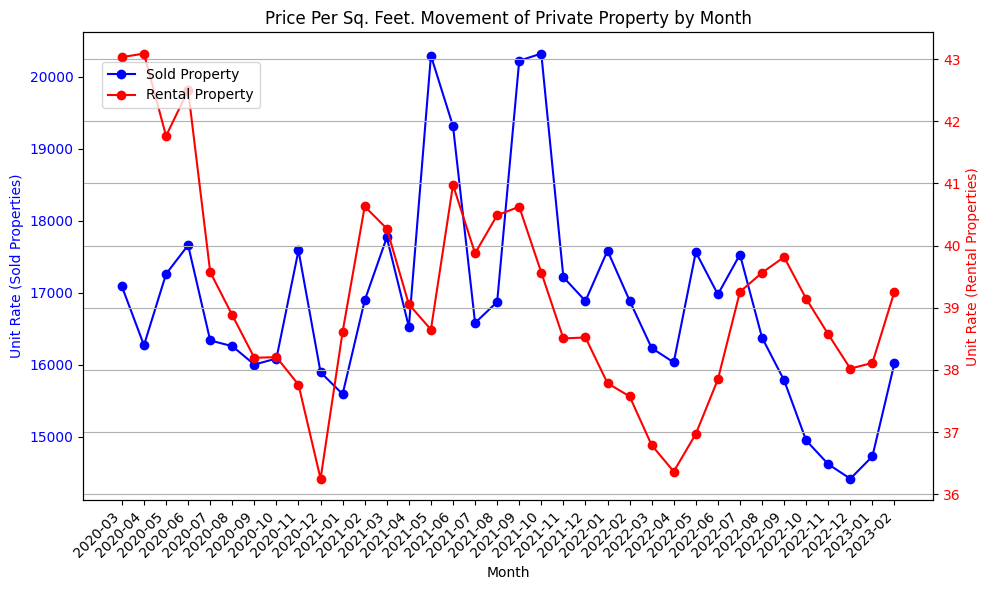

In [14]:
# Plotting with secondary Y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot sold properties on primary Y-axis
ax1.plot(sold_monthly.index.astype(str), sold_monthly.values, label='Sold Property', marker='o', color='b')
ax1.set_xlabel('Month')
ax1.set_ylabel('Unit Rate (Sold Properties)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Rotate x-axis labels and adjust spacing
plt.xticks(rotation=45, ha='right')  # Rotate the labels by 45 degrees and align them to the right
plt.subplots_adjust(bottom=0.2)  # Adjust the bottom margin to provide space for x-axis labels

# Create secondary Y-axis for rental properties
ax2 = ax1.twinx()
ax2.plot(rental_monthly.index.astype(str), rental_monthly.values, label='Rental Property', marker='o', color='r')
ax2.set_ylabel('Unit Rate (Rental Properties)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Adding title and legend
plt.title('Price Per Sq. Feet. Movement of Private Property by Month')
plt.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Show the plot
plt.grid(True)
plt.show()

### Look into The Movement of Transactions of Private Properties

It is observed that the number of transaction of both sold and rental properties stayed low throughout the whole year of 2020, both rental and selling market was slowly recovering from Q1 in 2021, with a stady increase of selling transactions recorded.

A significant increase in rental transactions at Q3 of 2022 suggests that more people are opting to rent rather than buy after the impact of COVID 19.


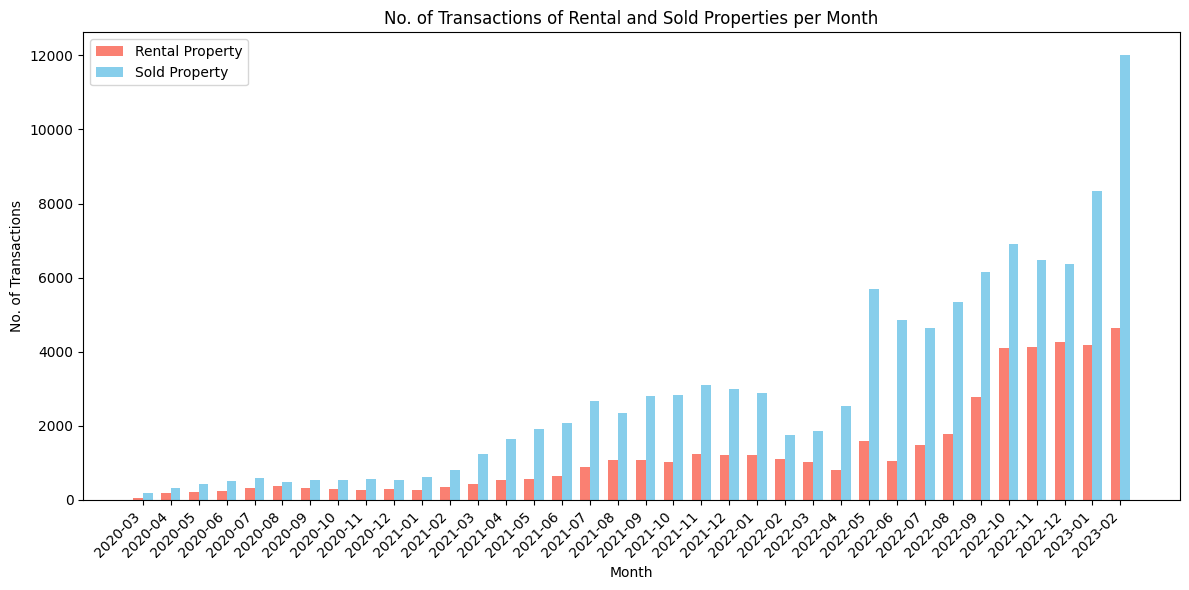

In [15]:
# Group by month and count transactions
rental_count = private_rental.groupby('month_year').size()
sold_count = private_sold.groupby('month_year').size()

# Combine the counts into a single DataFrame
transaction_counts = pd.DataFrame({
    'Sold': sold_count,
    'Rental': rental_count
    
}).fillna(0)

# Plotting the non-stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Define the width of the bars
bar_width = 0.35

# Define the positions of the bars
index = np.arange(len(transaction_counts))

# Plot the bars
bar1 = ax.bar(index, transaction_counts['Rental'], bar_width, label='Rental Property', color='salmon')
bar2 = ax.bar(index + bar_width, transaction_counts['Sold'], bar_width, label='Sold Property', color='skyblue')

# Adding labels and title
ax.set_xlabel('Month')
ax.set_ylabel('No. of Transactions')
ax.set_title('No. of Transactions of Rental and Sold Properties per Month')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(transaction_counts.index.astype(str), rotation=45, ha='right')
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

### Price distribution of Private Properties 

Price Distribution of Private Sold Properties
- Mean unit rate at 16449.64 HKD
- Most transactions occurs between 10,000 and 20,000 HKD per square foot
- The distribution is right-skewed, most transactions occurred at lower price

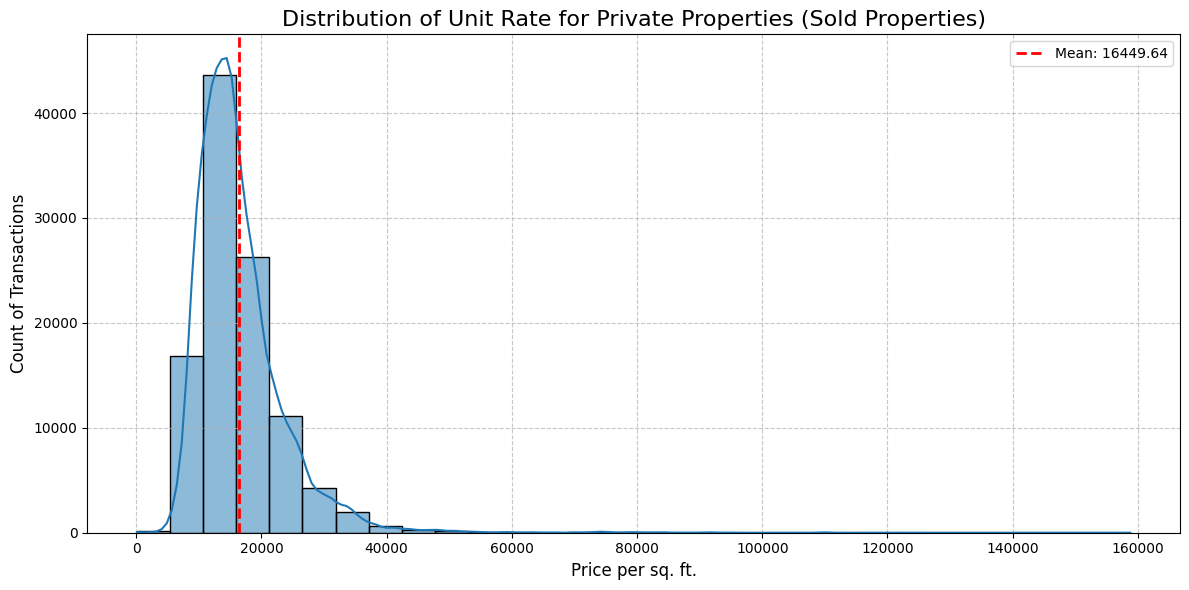

In [16]:
# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=private_sold, x='unit_rate', bins=30, kde=True)

# Customize the plot
plt.title('Distribution of Unit Rate for Private Properties (Sold Properties)', fontsize=16)
plt.xlabel('Price per sq. ft.', fontsize=12)
plt.ylabel('Count of Transactions', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Add a vertical line for the mean unit rate
mean_unit_rate = private_sold['unit_rate'].mean()
plt.axvline(mean_unit_rate, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_unit_rate:.2f}')

plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

### Price Distribution of Private Rental Properties
- Mean unit rate at 38.8 HKD
- Most transactions occur between approximately 30 and 50 HKD per square foot.
- Bell Shaped, Moderate Spread


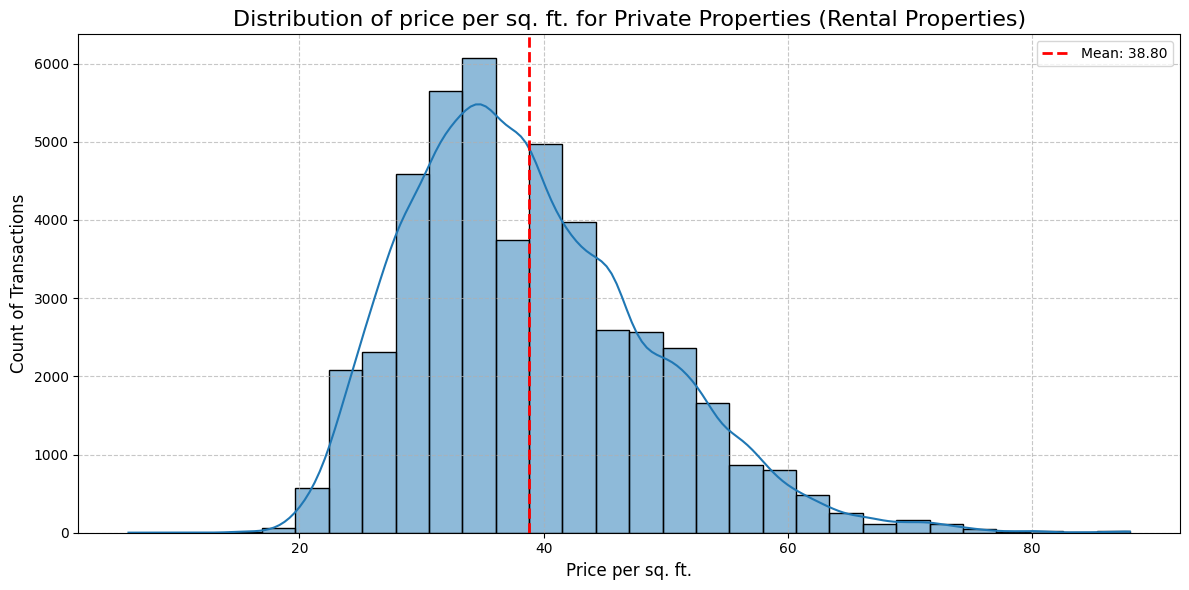

In [17]:
# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=private_rental, x='unit_rate', bins=30, kde=True)

# Customize the plot
plt.title('Distribution of price per sq. ft. for Private Properties (Rental Properties)', fontsize=16)
plt.xlabel('Price per sq. ft.', fontsize=12)
plt.ylabel('Count of Transactions', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Add a vertical line for the mean unit rate
mean_unit_rate = private_rental['unit_rate'].mean()
plt.axvline(mean_unit_rate, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_unit_rate:.2f}')

plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

### Price Movement of Private Property by Property Sizes

We divided property sizes into 3 categories:
- Small Properties: Less than 500 sq. ft.
- Medium Properties: Between 500 and 1000 sq. ft.
- Large Properties: Greater than 1000 sq. ft.
And plotted a stacked bar plot for both sold and rental market, showing their variation of transaction no. over time.

Both markets had a significant increase in transactions during Q1 of 2022.

For sold properties, small properties have largest transactions, whereas for rental properties,both small and medium properties have high demand.

Small properties have highest demand in both the selling and rental market.

Medium properties are more popular in the rental market than the selling market.


<Figure size 2000x1000 with 0 Axes>

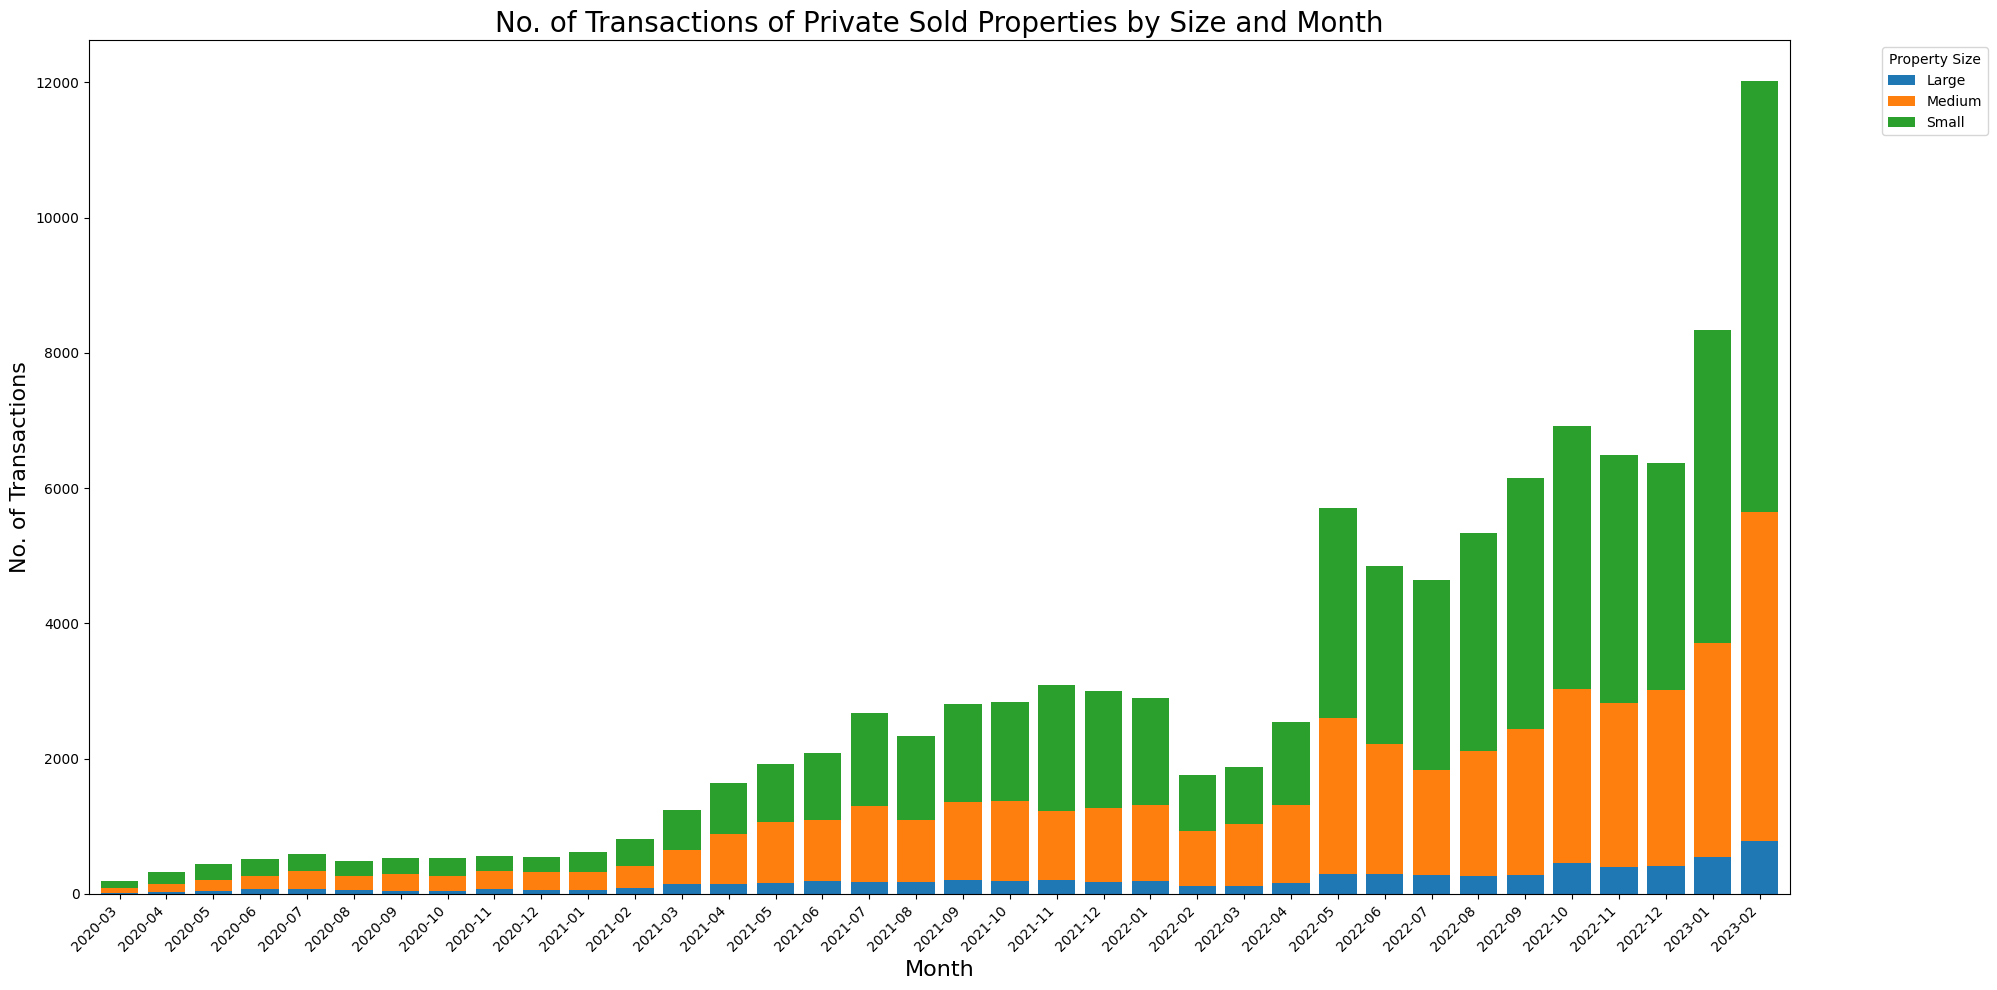

In [18]:
# Group by month and size category, then count transactions
transaction_counts = private_sold.groupby(['month_year', 'property_size']).size().unstack(fill_value=0)

# Plotting the stacked bar chart
plt.figure(figsize=(20, 10))  # Increased figure width
ax = transaction_counts.plot(kind='bar', stacked=True, figsize=(20, 10), width=0.8)  # Increased bar width

# Customizing the plot
plt.title('No. of Transactions of Private Sold Properties by Size and Month', fontsize=20)
plt.xlabel('Month', fontsize=16)
plt.ylabel('No. of Transactions', fontsize=16)
plt.legend(title='Property Size', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')

# Adjust x-axis labels to show every nth label
# n = 3  # Show every 3rd label
# for idx, label in enumerate(ax.xaxis.get_ticklabels()):
#     if idx % n != 0:
#         label.set_visible(False)

plt.tight_layout()

# Show the plot
plt.show()

<Figure size 2000x1000 with 0 Axes>

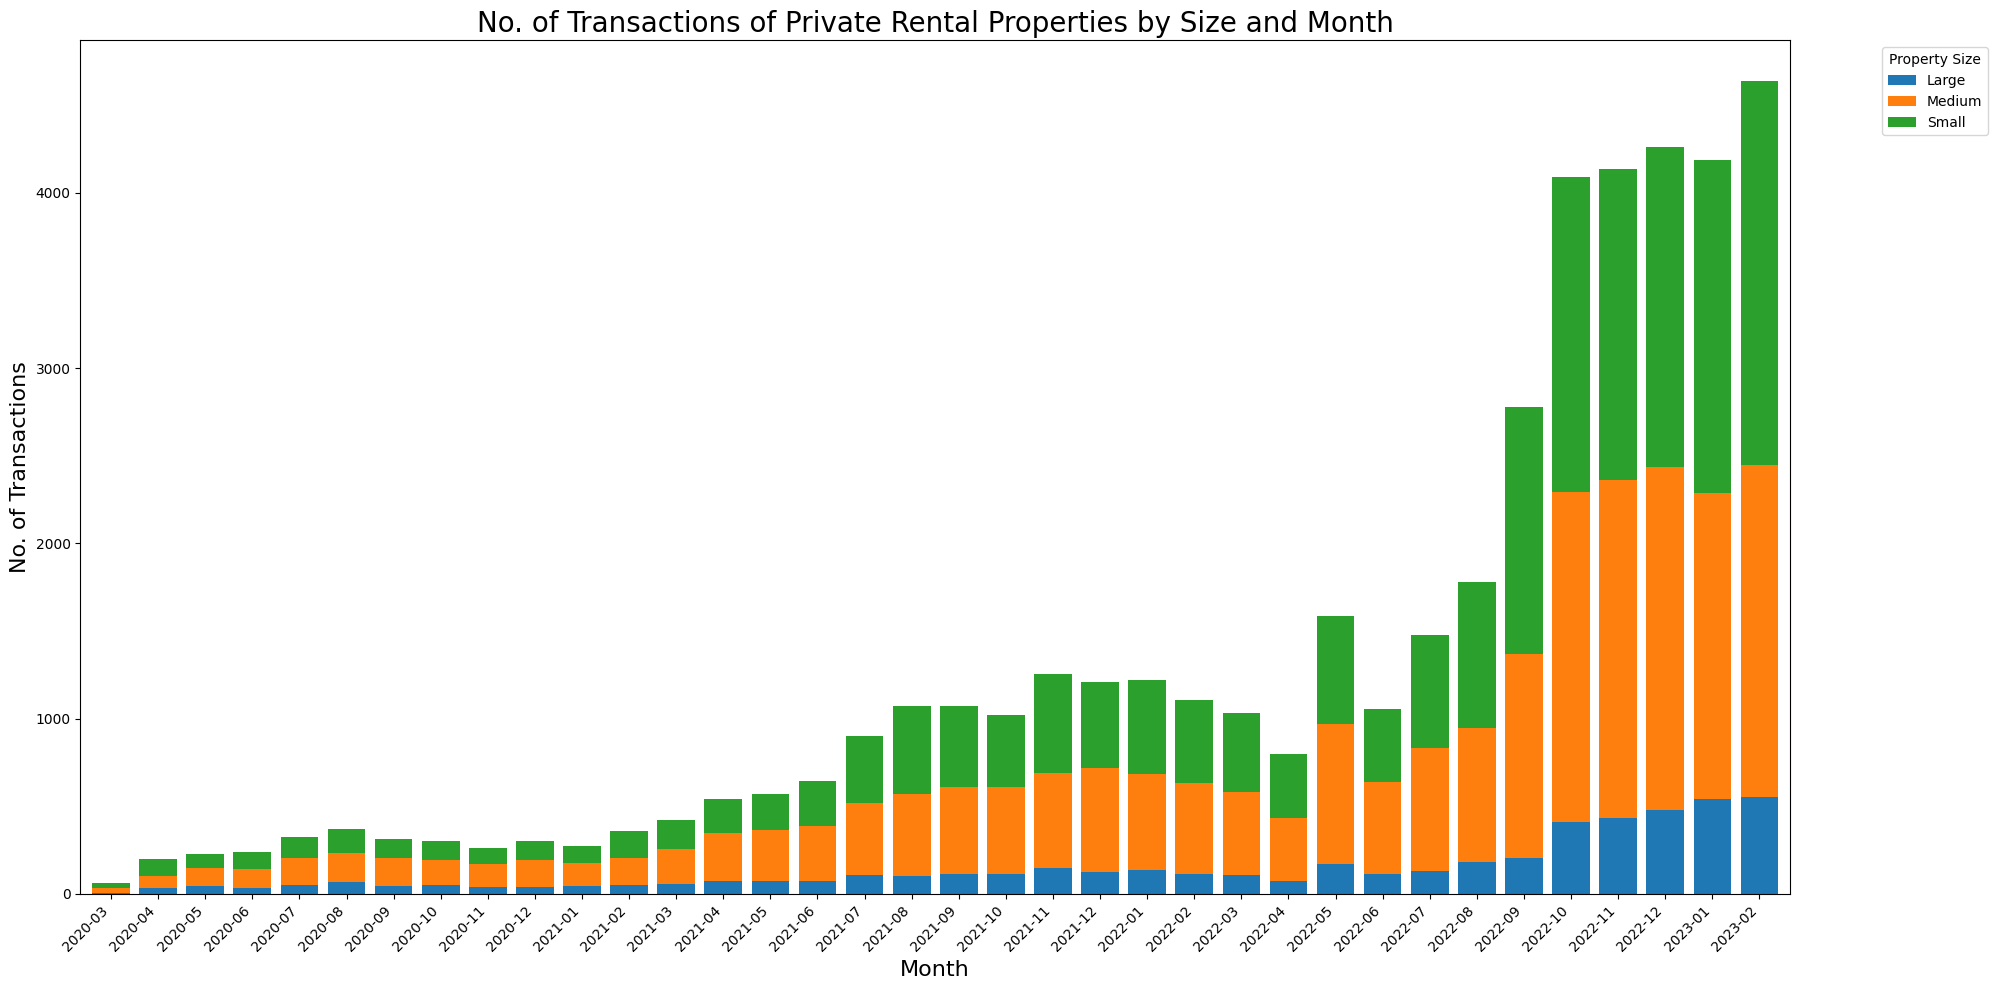

In [19]:
# Group by month and size category, then count transactions
transaction_counts_rental = private_rental.groupby(['month_year', 'property_size']).size().unstack(fill_value=0)

# Plotting the stacked bar chart
plt.figure(figsize=(20, 10))  # Increased figure width
ax = transaction_counts_rental.plot(kind='bar', stacked=True, figsize=(20, 10), width=0.8)  # Increased bar width

# Customizing the plot
plt.title('No. of Transactions of Private Rental Properties by Size and Month', fontsize=20)
plt.xlabel('Month', fontsize=16)
plt.ylabel('No. of Transactions', fontsize=16)
plt.legend(title='Property Size', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')

# Adjust x-axis labels to show every nth label
# n = 3  # Show every 3rd label
# for idx, label in enumerate(ax.xaxis.get_ticklabels()):
#     if idx % n != 0:
#         label.set_visible(False)

plt.tight_layout()

# Show the plot
plt.show()

### Investigate how property size relate with unit rate
Box plots for both markets are also plotted to investigate the relationship between size and unit price.

For Sold market:
Both small and medium properties have less variability and less outliers, which implies that they are more stable.
Small properties has a slightly higher selling price per sq. ft. than medium property

For Rental market:
Both small and large properties have high variability, whereas medium properties are more stable.

Insights:
Small property unit rates are stable for sold properties, but have a large variance in rental market, more probable to gain high rental yield , which is good for investors who buy properties for rental profit.
Medium properties unit rate are stable for both sold and rental properties, which is good for conservative investors.


C:\Users\aps20\AppData\Local\Temp\ipykernel_32640\1318210949.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  private_sold['property_size'] = private_sold['saleable_area(ft^2)'].apply(categorize_size)
C:\Users\aps20\AppData\Local\Temp\ipykernel_32640\1318210949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='unit_rate', y='property_size', data=private_sold, palette='Set3')


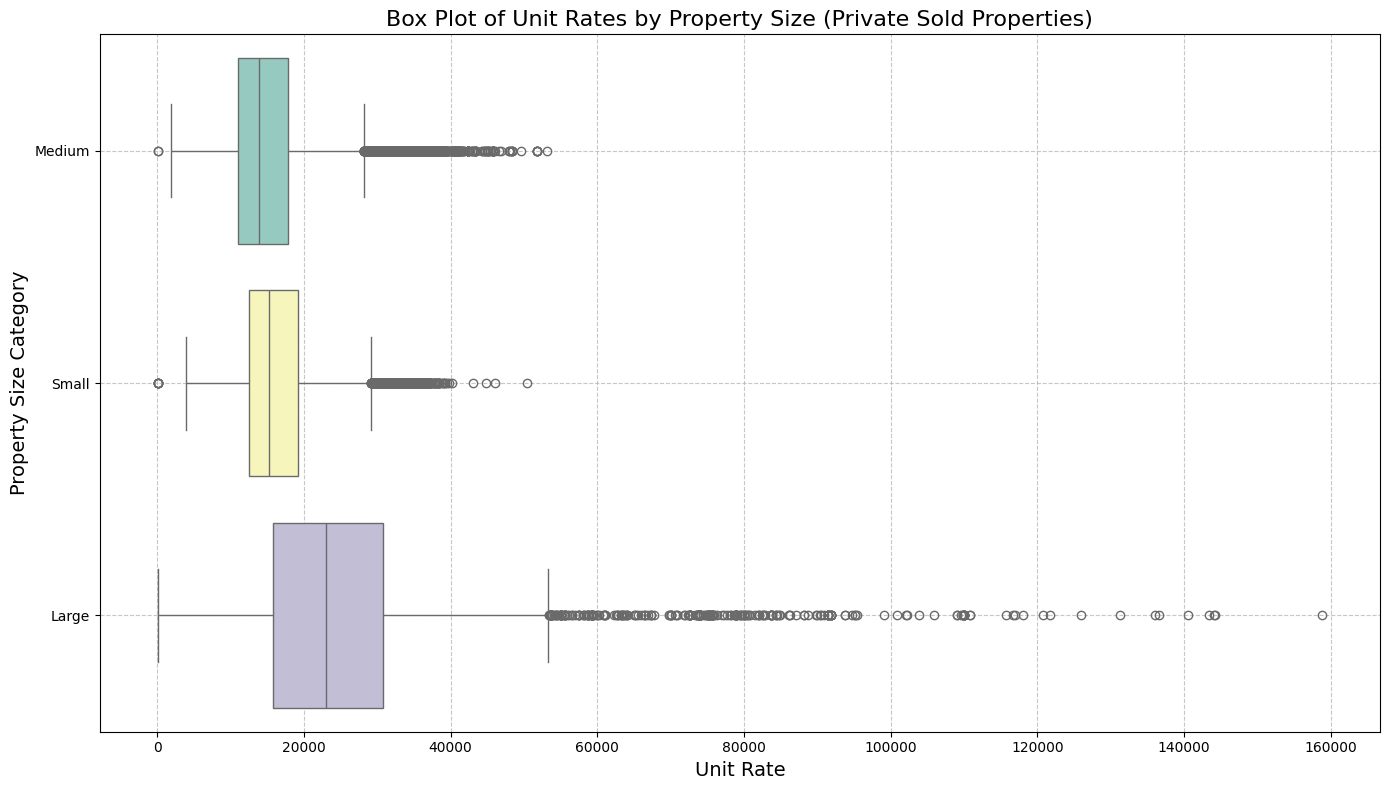

In [20]:
private_sold['property_size'] = private_sold['saleable_area(ft^2)'].apply(categorize_size)

# Plotting the box plot
plt.figure(figsize=(14, 8))  # Increase figure size for better readability
sns.boxplot(x='unit_rate', y='property_size', data=private_sold, palette='Set3')

# Customizing the plot
plt.title('Box Plot of Unit Rates by Property Size (Private Sold Properties)', fontsize=16)
plt.xlabel('Unit Rate', fontsize=14)
plt.ylabel('Property Size Category', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

C:\Users\aps20\AppData\Local\Temp\ipykernel_32640\3642845137.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  private_rental['property_size'] = private_rental['saleable_area(ft^2)'].apply(categorize_size)
C:\Users\aps20\AppData\Local\Temp\ipykernel_32640\3642845137.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='unit_rate', y='size_category', data=private_rental, palette='Set3')


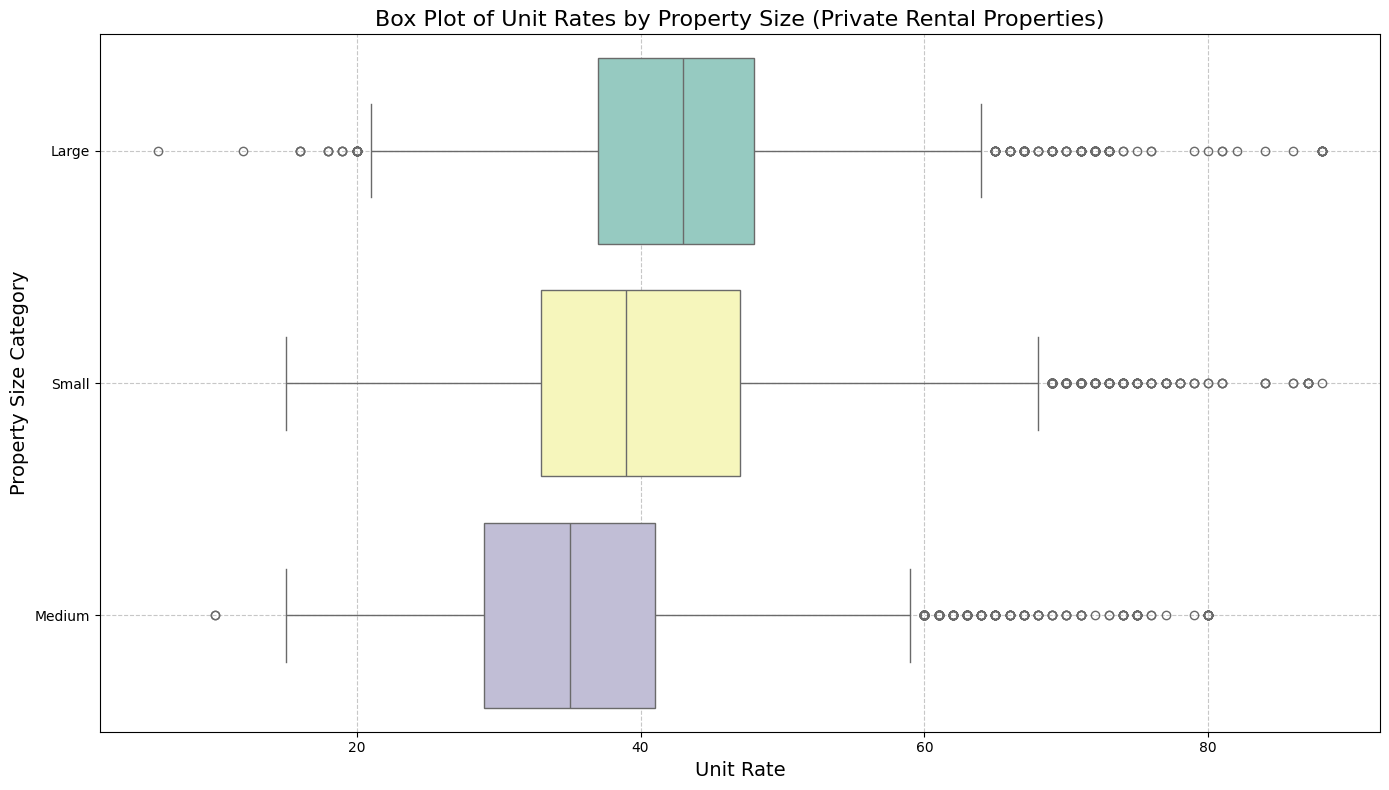

In [25]:
private_rental['property_size'] = private_rental['saleable_area(ft^2)'].apply(categorize_size)

# Convert 'size_category' to a categorical type with specified order
#private_rental['property_size'] = pd.Categorical(private_rental['property_size'], categories=size_categories, ordered=True)

# Plotting the box plot
plt.figure(figsize=(14, 8))  # Increase figure size for better readability
sns.boxplot(x='unit_rate', y='size_category', data=private_rental, palette='Set3')

# Customizing the plot
plt.title('Box Plot of Unit Rates by Property Size (Private Rental Properties)', fontsize=16)
plt.xlabel('Unit Rate', fontsize=14)
plt.ylabel('Property Size Category', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

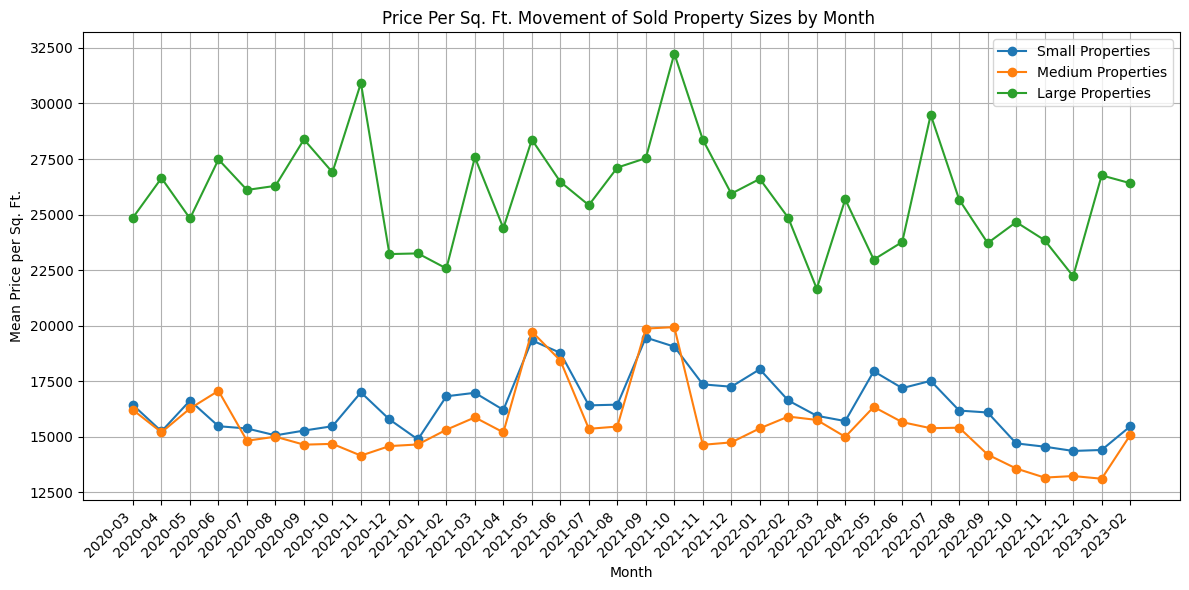

In [ ]:
# Group by month and property size, then calculate the mean unit rate
private_sold_rate_by_size = private_sold.groupby(['month_year', 'property_size'])['unit_rate'].mean().unstack()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(private_sold_rate_by_size.index.astype(str), private_sold_rate_by_size['Small'], label='Small Properties', marker='o')
plt.plot(private_sold_rate_by_size.index.astype(str), private_sold_rate_by_size['Medium'], label='Medium Properties', marker='o')
plt.plot(private_sold_rate_by_size.index.astype(str), private_sold_rate_by_size['Large'], label='Large Properties', marker='o')

# Adding labels and title
plt.xlabel('Month')
plt.ylabel('Mean Price per Sq. Ft.')
plt.title('Price Per Sq. Ft. Movement of Sold Property Sizes by Month ')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

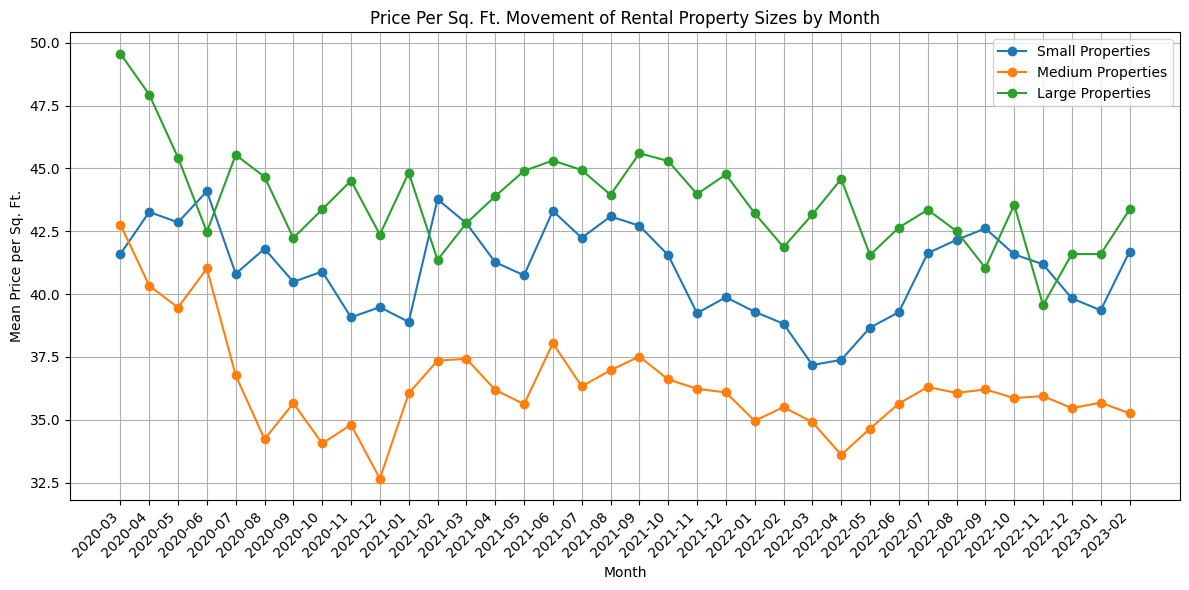

In [ ]:
# Group by month and property size, then calculate the mean unit rate
private_rent_rate_by_size = private_rental.groupby(['month_year', 'property_size'])['unit_rate'].mean().unstack()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(private_rent_rate_by_size.index.astype(str), private_rent_rate_by_size['Small'], label='Small Properties', marker='o')
plt.plot(private_rent_rate_by_size.index.astype(str), private_rent_rate_by_size['Medium'], label='Medium Properties', marker='o')
plt.plot(private_rent_rate_by_size.index.astype(str), private_rent_rate_by_size['Large'], label='Large Properties', marker='o')

# Adding labels and title
plt.xlabel('Month')
plt.ylabel('Mean Price per Sq. Ft.')
plt.title('Price Per Sq. Ft. Movement of Rental Property Sizes by Month')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

### Investigation of the effect of Districts


Box plots for both markets are plotted to investigate the relationship between district and unit price.
We have categorized 18 districts of Hong Kong into 4 big categories:
- Hong Kong Island
- Kowloon
- New Territories East
- New territories West

Lets take a look at a general overview of selling market price distribution among different regions.

As the graphs has shown:
- Hong Kong Island has the highest mean with the most outliers
- Kowloon has the second highest mean with a considerable amount of outliers.
- Both Kowloon and Hong Kong has large IQR range
- New territories West has the least unit rate distribution.

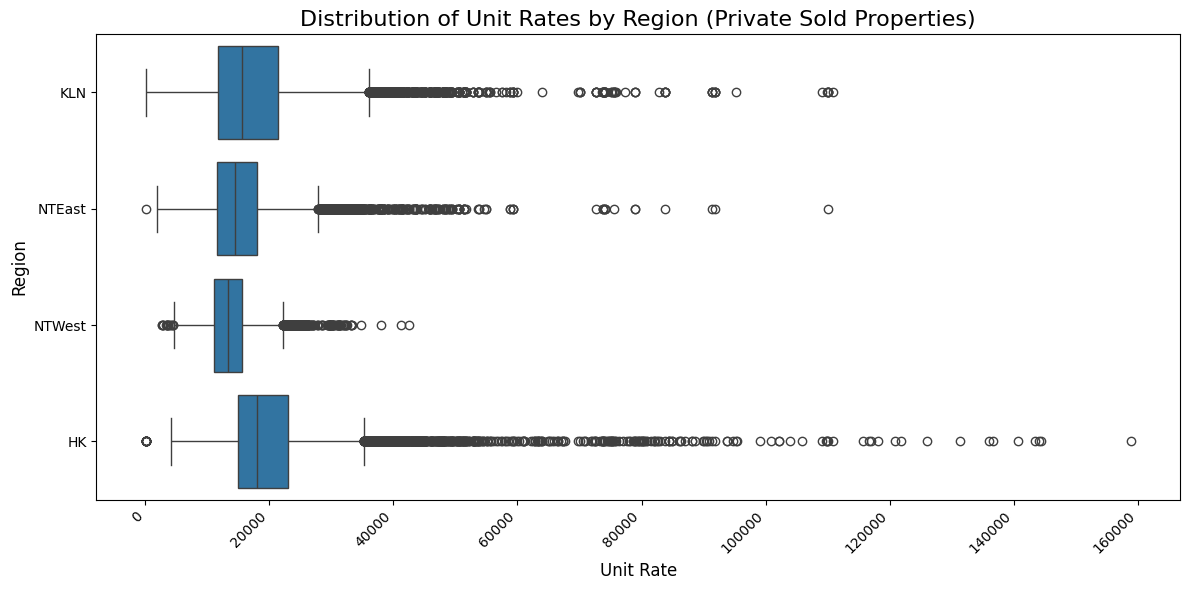

In [ ]:
# Plotting box plot for private sold properties
plt.figure(figsize=(12, 6))
sns.boxplot(x='unit_rate', y='region', data = private_sold)

# Customize the plot
plt.title('Distribution of Unit Rates by Region (Private Sold Properties)', fontsize=16)
plt.xlabel('Unit Rate', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

When we look deeper into each district:
Districts with High Unit Price:
- Wan Chai District
- HK Island Southern District
- Central and Western District

Districts with Low Unit Price:
- Kwun Tong District
- Wong Tai Sin District
- Sham Shui Po District
- West Islands District

Districts with great disparity (with a large IQR range):
- Central and Western District
- Kowloon City


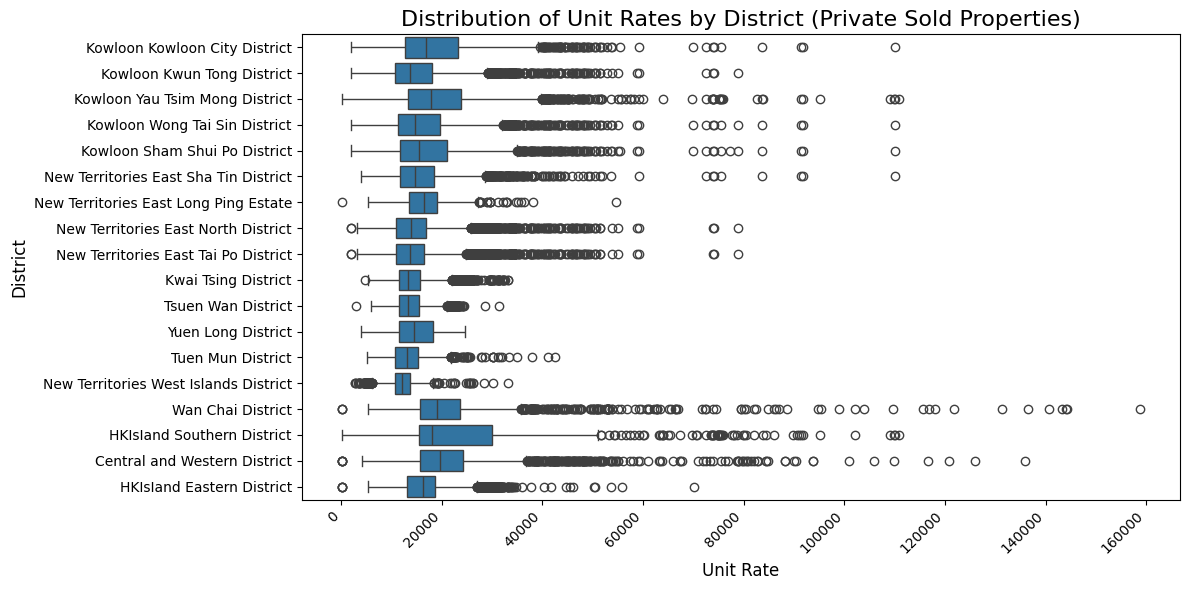

In [ ]:
# Plotting box plot for private sold properties
plt.figure(figsize=(12, 6))
sns.boxplot(x='unit_rate', y='district', data = private_sold)

# Customize the plot
plt.title('Distribution of Unit Rates by District (Private Sold Properties)', fontsize=16)
plt.xlabel('Unit Rate', fontsize=12)
plt.ylabel('District', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()



Lets take a look at a general overview of rental market price distribution among different regions.

As the graphs has shown:
- Hong Kong Island has the highest mean, widest IQR range with the most outliers
- Kowloon has the second highest mean with a considerable amount of outliers.
- New territories West has the least unit rate distribution.

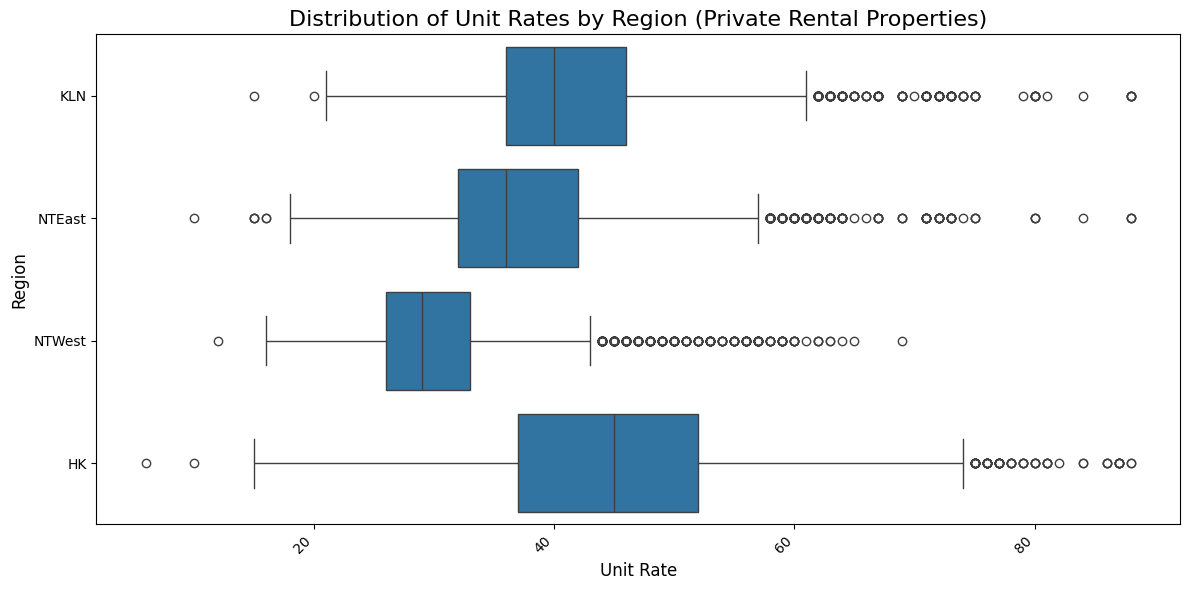

In [ ]:
# Plotting box plot for private rental properties
plt.figure(figsize=(12, 6))
sns.boxplot(x='unit_rate', y='region', data = private_rental)

# Customize the plot
plt.title('Distribution of Unit Rates by Region (Private Rental Properties)', fontsize=16)
plt.xlabel('Unit Rate', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

When we look deeper into each district:
Districts with High Unit Price:
- Wan Chai District
- Kowloon Yau Tsim Mong District
- Central and Western District

Districts with Low Unit Price:
- Yuen Long District
- Tuen Mun District
- West Islands District

Districts with great disparity (with a large IQR range):
- Central and Western District
- New Territories East North District

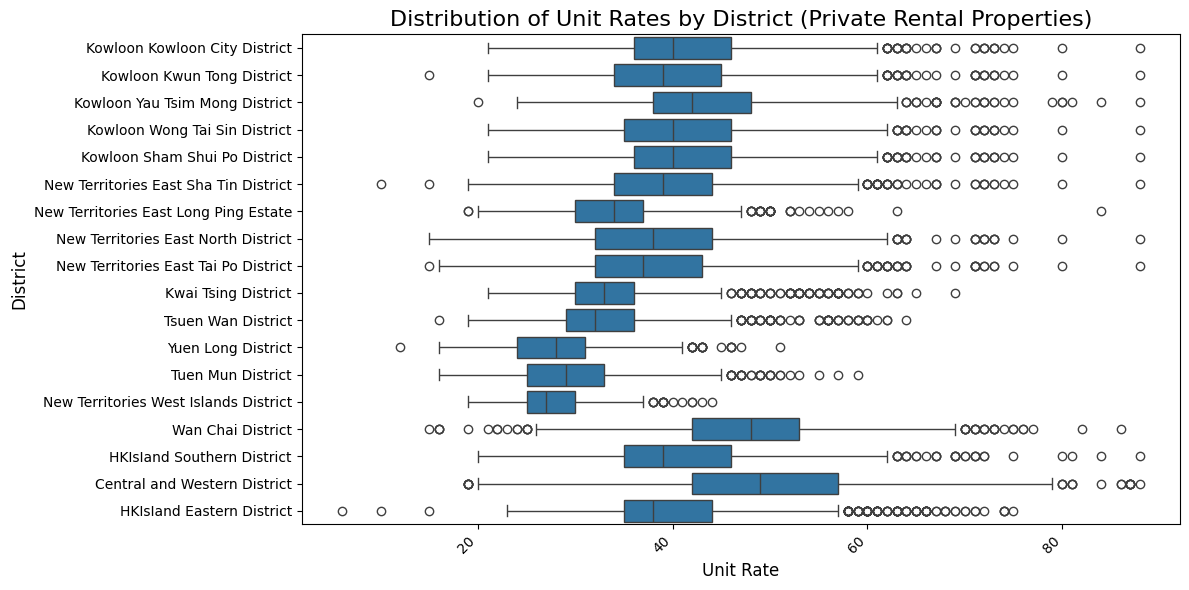

In [ ]:
# Plotting box plot for private rental properties
plt.figure(figsize=(12, 6))
sns.boxplot(x='unit_rate', y='district', data = private_rental)

# Customize the plot
plt.title('Distribution of Unit Rates by District (Private Rental Properties)', fontsize=16)
plt.xlabel('Unit Rate', fontsize=12)
plt.ylabel('District', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()


After looking at the distribution of price among different districts, lets look at the price movements of each region for both markets against time. We can observe that the unit rate is in a downward trend for both markets, which is consistent with our first finding above.

- High-Value Peaks:
	-  Certain districts like HK Island Southern show sharp spikes in price per square foot, indicating periods of high market activity or premium property sales.
- Consistency in Lower-Price Districts:
	- Districts with lower prices, such as New Territories districts, exhibit more stable trends with less fluctuation compared to high-price districts.


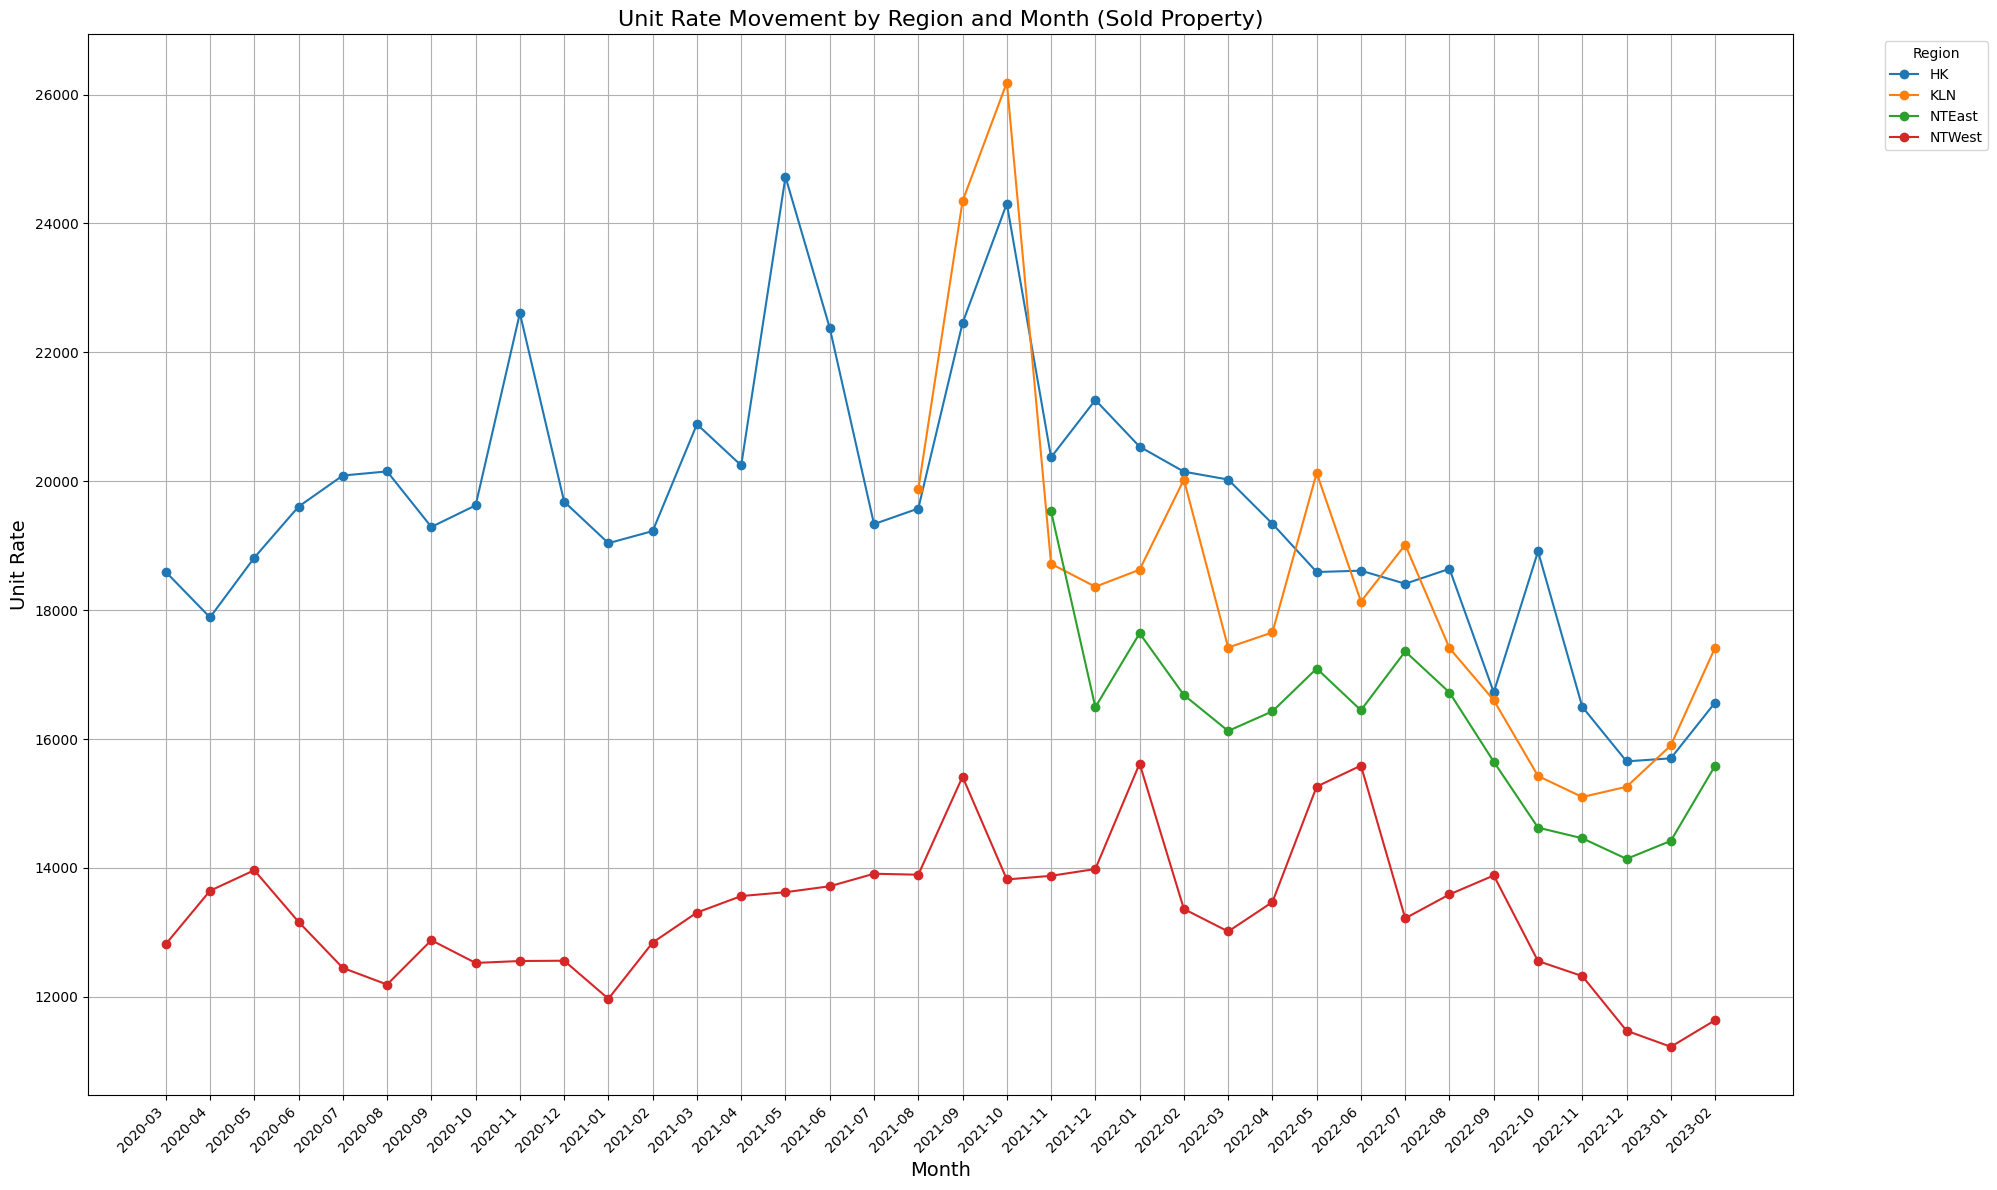

In [ ]:
# Group by region and month_year, then calculate the mean unit rate
unit_rate_by_region_sold = private_sold.groupby(['region', 'month_year'])['unit_rate'].mean().unstack()

# Plotting
plt.figure(figsize=(20, 12))

# Plot each region's unit rate movement
for region in unit_rate_by_region_sold.index:
    plt.plot(unit_rate_by_region_sold.columns.astype(str), unit_rate_by_region_sold.loc[region], label=region, marker='o')

# Adding labels and title
plt.xlabel('Month', fontsize=14)
plt.ylabel('Unit Rate', fontsize=14)
plt.title('Unit Rate Movement by Region and Month (Sold Property)', fontsize=16)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

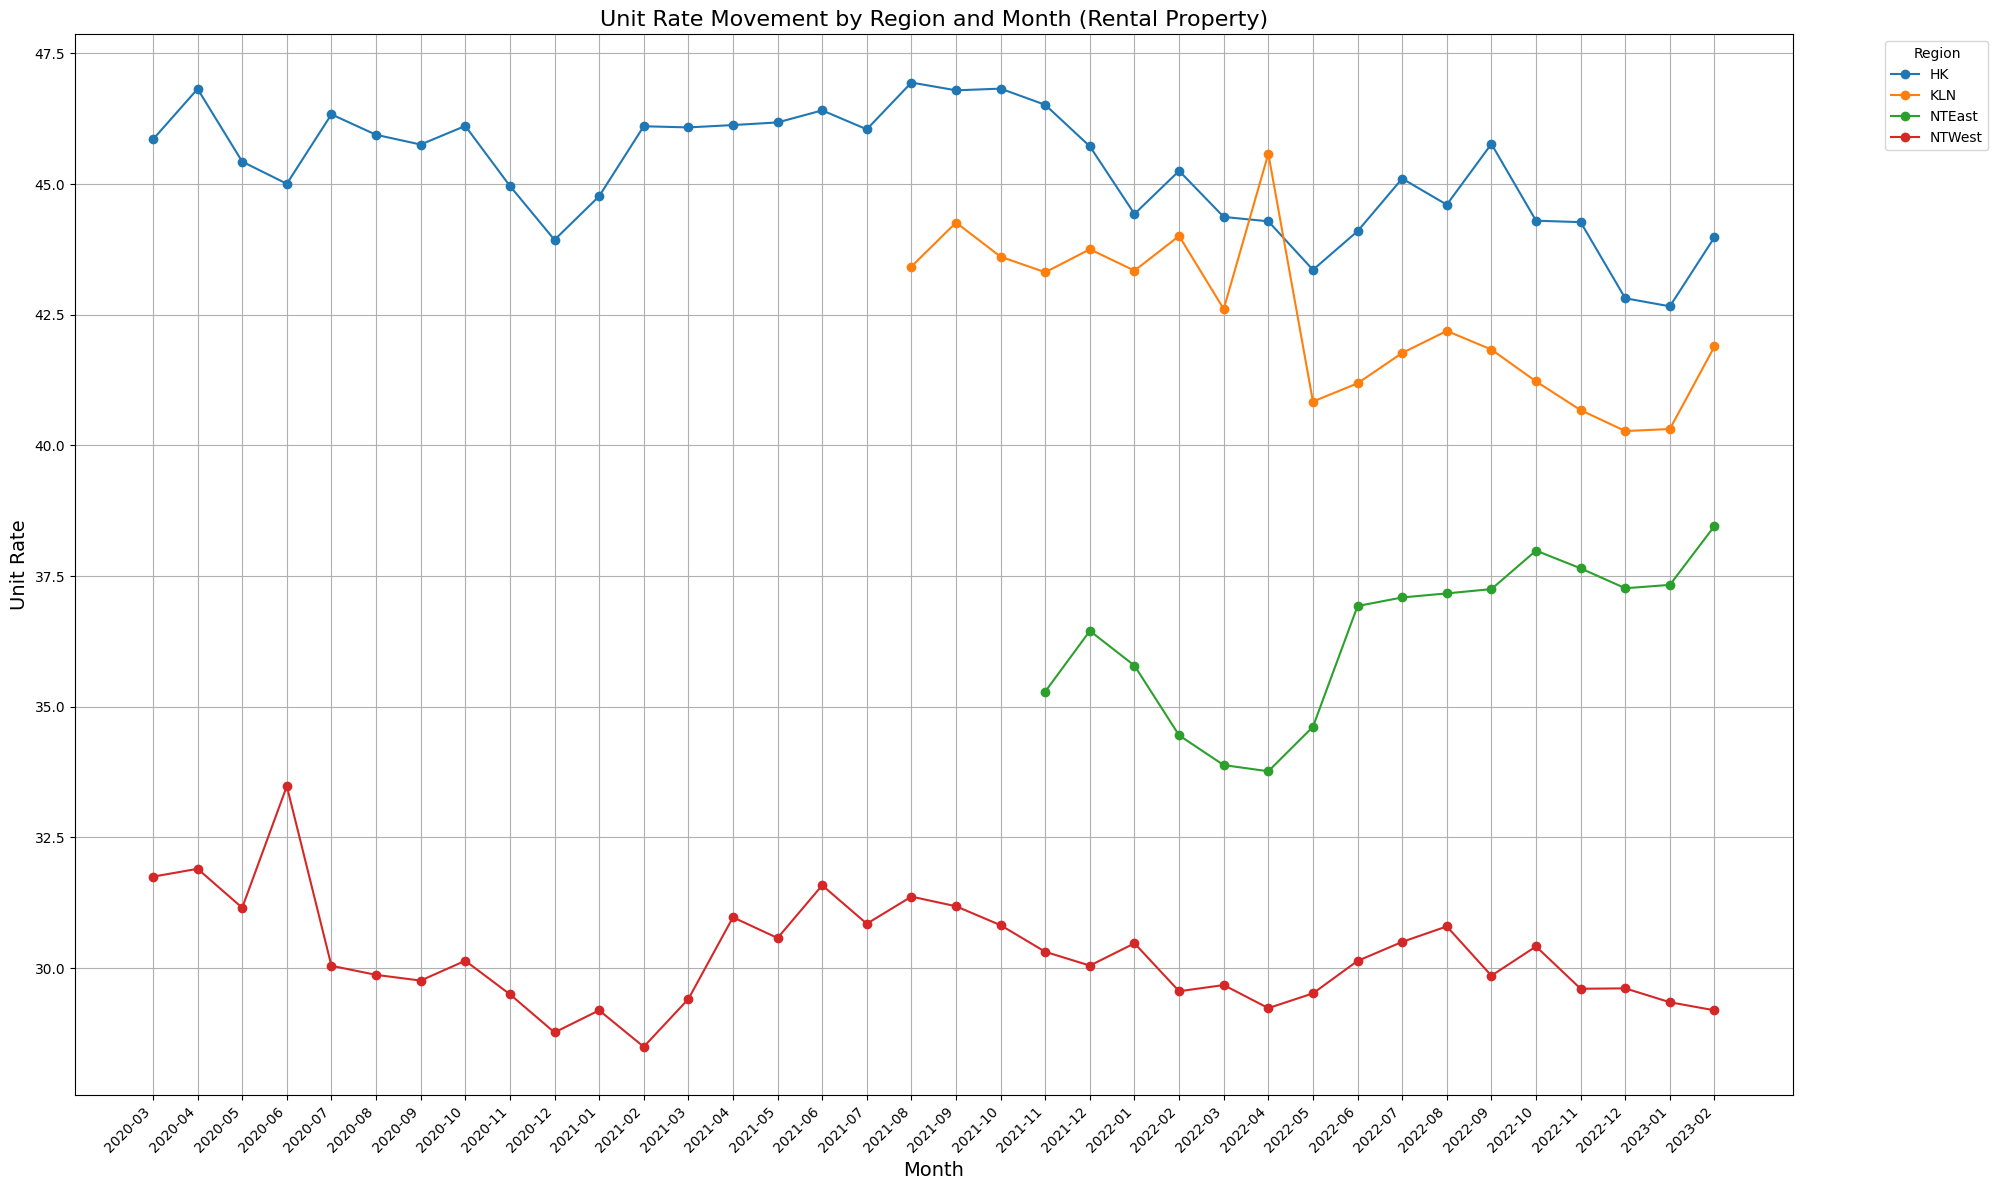

In [ ]:
# Group by region and month_year, then calculate the mean unit rate
unit_rate_by_region_rent = private_rental.groupby(['region', 'month_year'])['unit_rate'].mean().unstack()

# Plotting
plt.figure(figsize=(20, 12))

# Plot each region's unit rate movement
for region in unit_rate_by_region.index:
    plt.plot(unit_rate_by_region_rent.columns.astype(str), unit_rate_by_region_rent.loc[region], label=region, marker='o')

# Adding labels and title
plt.xlabel('Month', fontsize=14)
plt.ylabel('Unit Rate', fontsize=14)
plt.title('Unit Rate Movement by Region and Month (Rental Property)', fontsize=16)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

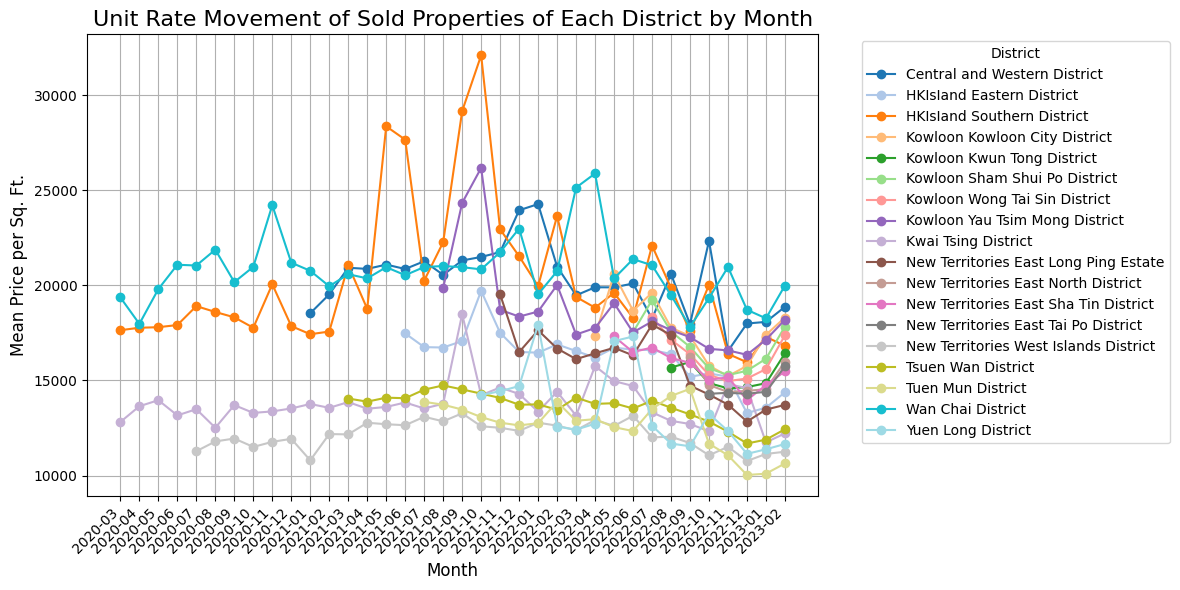

In [ ]:

# Group by district and month_year, then calculate the mean unit rate
unit_rate_by_district_sold = private_sold.groupby(['district', 'month_year'])['unit_rate'].mean().unstack()

# Get the list of districts
districts = unit_rate_by_district_sold.index

# Generate a colormap with a unique color for each district
colors = cm.tab20(np.linspace(0, 1, len(districts)))

# Plotting
plt.figure(figsize=(12, 6))

# Plot each district's unit rate movement
for district, color in zip(districts, colors):
    plt.plot(unit_rate_by_district_sold.columns.astype(str), unit_rate_by_district_sold.loc[district], label=district, color=color, marker='o')

# Adding labels and title
plt.xlabel('Month', fontsize=12)
plt.ylabel('Mean Price per Sq. Ft.', fontsize=12)
plt.title('Unit Rate Movement of Sold Properties of Each District by Month', fontsize=16)
plt.legend(title='District', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

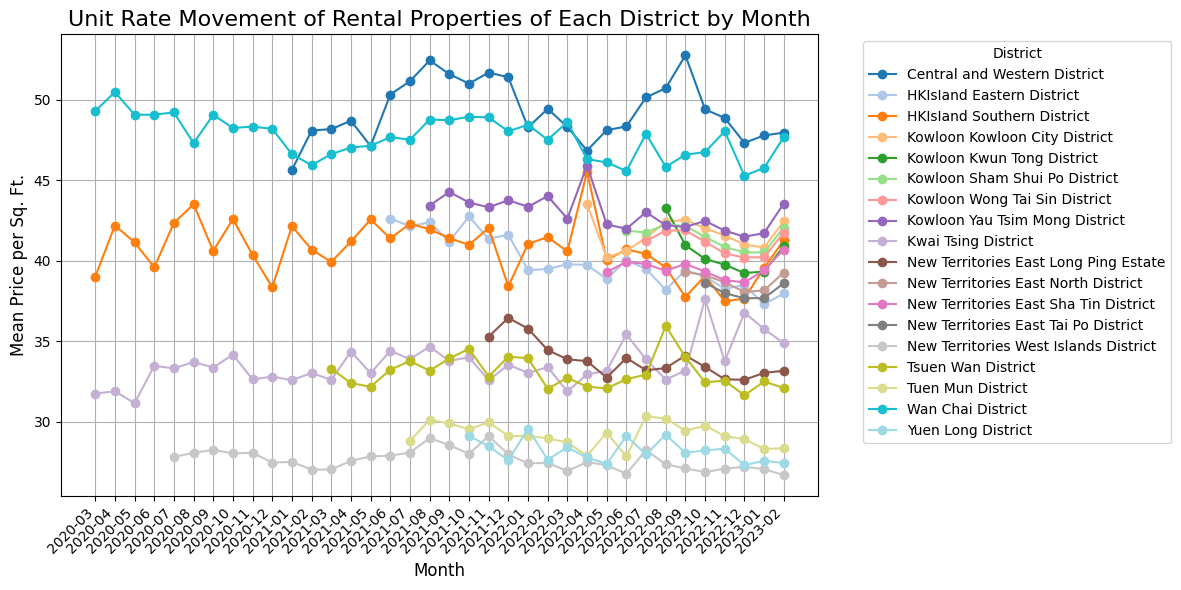

In [ ]:
# Group by district and month_year, then calculate the mean unit rate
unit_rate_by_district_rent = private_rental.groupby(['district', 'month_year'])['unit_rate'].mean().unstack()

# Get the list of districts
districts = unit_rate_by_district_rent.index

# Generate a colormap with a unique color for each district
colors = cm.tab20(np.linspace(0, 1, len(districts)))

# Plotting
plt.figure(figsize=(12, 6))

# Plot each district's unit rate movement
for district, color in zip(districts, colors):
    plt.plot(unit_rate_by_district_rent.columns.astype(str), unit_rate_by_district_rent.loc[district], label=district, color=color, marker='o')

# Adding labels and title
plt.xlabel('Month', fontsize=12)
plt.ylabel('Mean Price per Sq. Ft.', fontsize=12)
plt.title('Unit Rate Movement of Rental Properties of Each District by Month', fontsize=16)
plt.legend(title='District', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

### Investigating the change of demand of different regions

To investigate the change of demand of selling and rental market, astacked bar plot representing the number of transactions of private properties by region and month are plotted.

For Market of Sold Properties:
- KLN (Kowloon) and NTWest (New Territories West) regions have the highest number of transactions, especially towards the end of the period.
- HK (Hong Kong Island) and NTEast (New Territories East) have relatively fewer transactions compared to KLN and NTWest.
- HK (Hong Kong Island) andNTWest (New Territories West) has a consistent demand across the whole period of record.


<Figure size 1200x600 with 0 Axes>

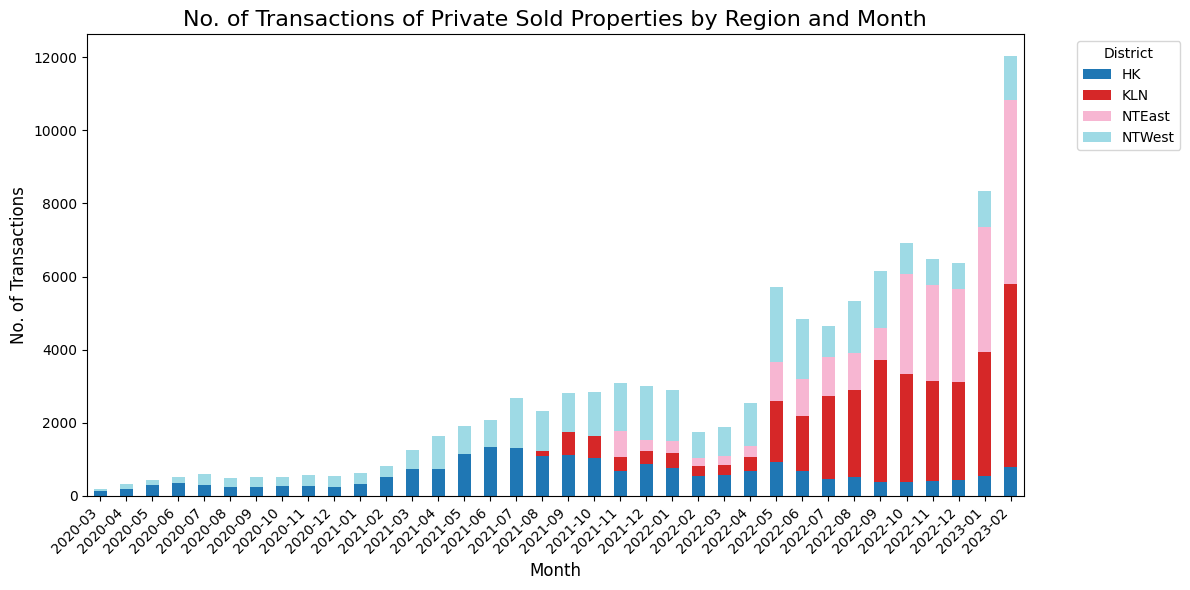

In [ ]:
# Group by month and district, then count transactions
tcount_sold_by_region = private_sold.groupby(['month_year', 'region']).size().unstack(fill_value=0)

# Plotting the stacked bar chart
plt.figure(figsize=(12, 6))
tcount_sold_by_region.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')

# Customizing the plot
plt.title('No. of Transactions of Private Sold Properties by Region and Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('No. of Transactions', fontsize=12)
plt.legend(title='District', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

For Market of Rental Properties:
- KLN (Kowloon) and NTWest (New Territories East) regions have the highest number of transactions, especially towards the end of the period.
- HK (Hong Kong Island) andNTWest (New Territories West) has a consistent demand across the whole period of record.

<Figure size 1200x600 with 0 Axes>

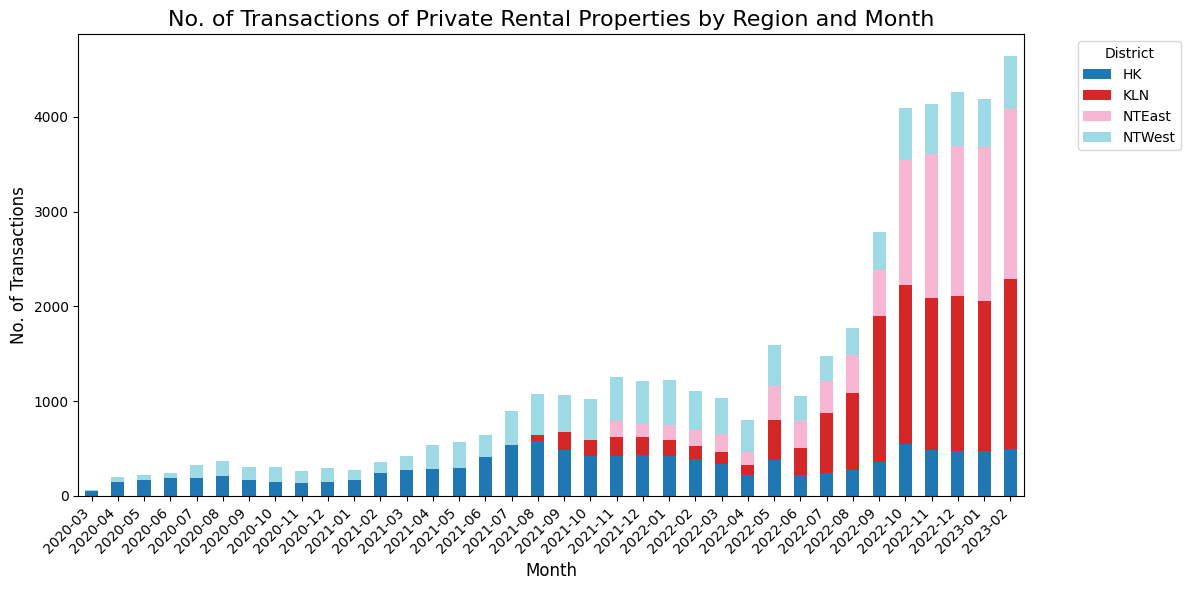

In [ ]:
# Group by month and district, then count transactions
tcount_rent_by_region = private_rental.groupby(['month_year', 'region']).size().unstack(fill_value=0)

# Plotting the stacked bar chart
plt.figure(figsize=(12, 6))
tcount_rent_by_region.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')

# Customizing the plot
plt.title('No. of Transactions of Private Rental Properties by Region and Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('No. of Transactions', fontsize=12)
plt.legend(title='District', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

A more detailed stacked bar plot about the demand of each district is plotted as follows:

In [ ]:
# Group by month and district, then count transactions
tcount_sold_by_district = private_sold.groupby(['month_year', 'district']).size().unstack(fill_value=0)

# Plotting the stacked bar chart
plt.figure(figsize=(12, 6))
tcount_sold_by_district.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')

# Customizing the plot
plt.title('No. of Transactions of Private Sold Properties by District and Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('No. of Transactions', fontsize=12)
plt.legend(title='District', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

NameError: name 'private_sold' is not defined

<Figure size 1200x600 with 0 Axes>

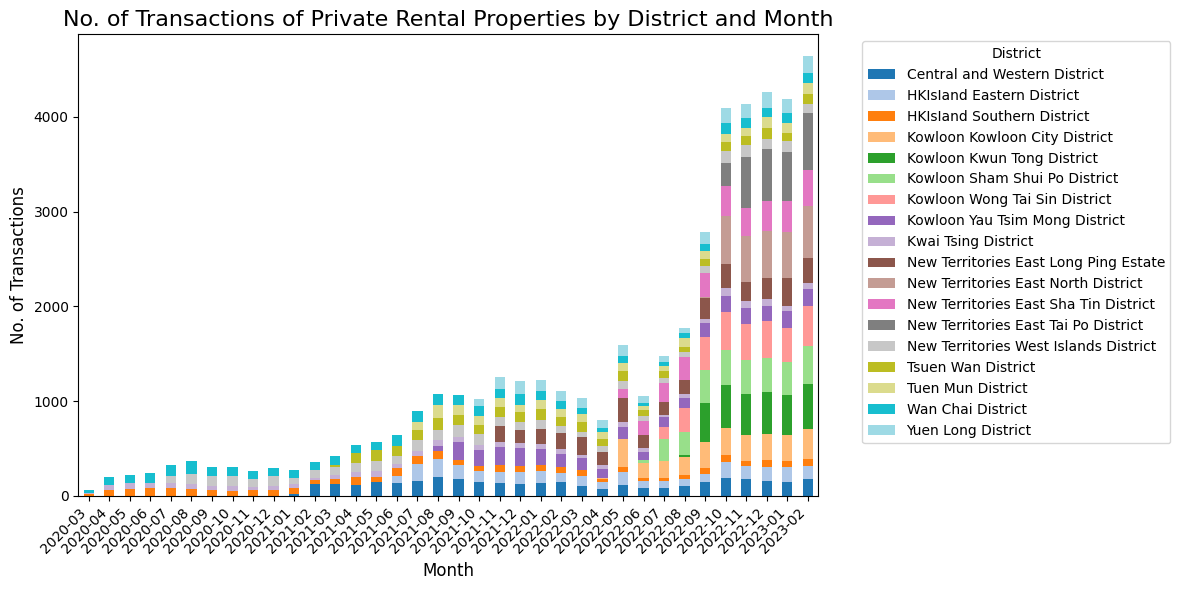

In [ ]:
# Group by month and district, then count transactions
tcount_rent_by_district = private_rental.groupby(['month_year', 'district']).size().unstack(fill_value=0)

# Plotting the stacked bar chart
plt.figure(figsize=(12, 6))
tcount_rent_by_district.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')

# Customizing the plot
plt.title('No. of Transactions of Private Rental Properties by District and Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('No. of Transactions', fontsize=12)
plt.legend(title='District', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()